<a href="https://colab.research.google.com/github/devparikh0506/DATA-601/blob/main/week_4/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1

## Sentiment Analysis of Amazon reviews

## Data source

The data for this project can be found at: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

In [1]:
!pip install nltk

### Importing libraries

In [2]:
import pandas as pd
from string import punctuation
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import json

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Loading data

In [19]:
file = './amazon_cells_labelled.txt'

def load_data(file, columns):
  try:
    df = pd.read_csv(file, sep='\t', header=None)
    df.columns = columns
    return df
  except Exception as e:
    raise Exception(f"Error loading data: {e}")
    # return pd.DataFrame([], columns=columns)

df = load_data(file, ['review', 'sentiment'])
df.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### Inspecting data

In [20]:
df.shape

(1000, 2)

In [21]:
df.describe()

,sentiment
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [22]:
df.isna().sum()

,0
review,0
sentiment,0


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

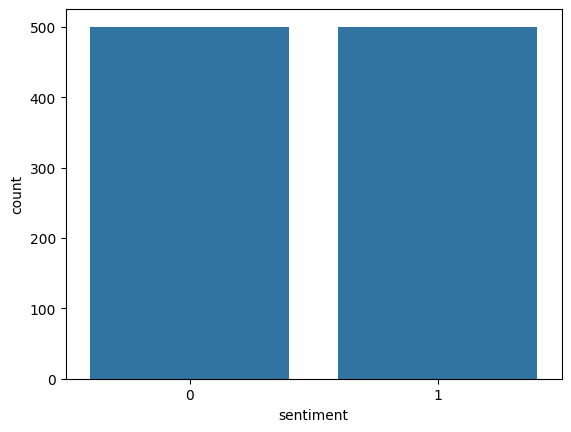

In [24]:
sns.countplot(x='sentiment', data=df)
plt.show()

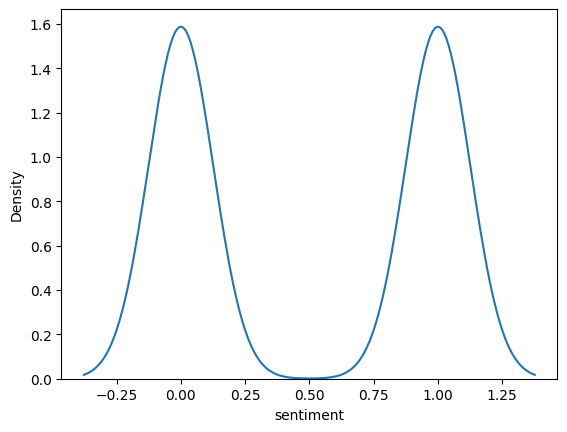

In [25]:
sns.kdeplot(x='sentiment', data=df)
plt.show()

### Spliting data into reviews and labels

In [26]:
reviews = df['review'].values
labels = df['sentiment'].values

### Preprocessing reviews

Steps include:
1. removing punctuations
2. spliting sentences into words
3. converting words to token
4. creating word-token mapping
5. creating a vocab from all words

In [27]:
def prerpocess_reviews(reviews):
  clean_reviews = []

  # removing punctuation
  for review in reviews:
        clean_reviews.append(review.translate(str.maketrans('', '', punctuation)).lower().rstrip())

  # splitting sentences into words and tokeninzing them
  tokenized_reviews = [word_tokenize(x) for x in clean_reviews]
  all_reviews = []

  for single_tokenized_review in tokenized_reviews:
    all_reviews.extend(single_tokenized_review)

  vocab = set(all_reviews)

  return tokenized_reviews, vocab

In [28]:
tokenized_reviews, vocab = prerpocess_reviews(reviews)

#### dictionary for vocab

In [29]:
def create_vocab_dict(vocab):
  vocab_to_int = {word: i+1 for i, word in enumerate(vocab)}
  int_to_vocab = {i:word for word, i in vocab_to_int.items()}

  return vocab_to_int, int_to_vocab

In [30]:
vocab_to_int_dict, int_to_vocab_dict = create_vocab_dict(vocab)

#### Replacing words with integers

#### Function for padding review to max possible length of review

In [31]:
int_to_vocab_dict[0] = ''
vocab_to_int_dict[''] = 0

In [32]:
def pad_reviews(tokenized_reviews, seq_length):
    for review in tokenized_reviews:
        if len(review) >= seq_length:
            yield review[:seq_length]
        else:
            yield [''] * (seq_length - len(review)) + review

#### Encode function for review

In [33]:
def encode_reviews(tokenized_reviews, vocab_to_int_dict):
  max_sentence_length = np.max([len(x) for x in tokenized_reviews])
  print("Maximum sentence length found:", max_sentence_length)
  converted_reviews = [[vocab_to_int_dict[word] for word in review] for review in pad_reviews(tokenized_reviews, max_sentence_length)]
  if len(converted_reviews) != len(tokenized_reviews):
    raise Exception("Reviews length mismatch")
  print(f"Reviews successfully padded and converted to match length: {max_sentence_length}")
  return np.array(converted_reviews)


In [34]:
encoded_reviews = encode_reviews(tokenized_reviews, vocab_to_int_dict)

Maximum sentence length found: 30
Reviews successfully padded and converted to match length: 30


In [35]:
encoded_reviews[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  332,  580,
        594, 1315,  821, 1399, 1487, 1898, 1891, 1513, 1428,  752, 1428,
        124,  291, 1881, 1161,  930, 1062,  444, 1740])

## Defining Neural Network

In [36]:
class SentimentLSTM(nn.Module):
  def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.8):
    super().__init__()

    self.n_vocab = n_vocab
    self.n_layers = n_layers
    self.n_hidden = n_hidden

    # Embedding layer
    self.embedding = nn.Embedding(n_vocab, n_embed)

    # LSTM layer initialization
    self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
    self.dropout = nn.Dropout(drop_p)
    self.fc = nn.Linear(n_hidden, n_output)
    self.sigmoid = nn.Sigmoid()

  def forward (self, input_words):
    """
    Function for performing forward pass of the network
    """
    batch_size = input_words.size(0)
    embedded_words = self.embedding(input_words)
    lstm_out, h = self.lstm(embedded_words)
    lstm_out = self.dropout(lstm_out)
    lstm_out = lstm_out.contiguous().view(-1, self.n_hidden)
    fc_out = self.fc(lstm_out)
    sigmoid_out = self.sigmoid(fc_out)
    sigmoid_out = sigmoid_out.view(batch_size, -1)

    sigmoid_last = sigmoid_out[:, -1]

    return sigmoid_last, h


  def init_hidden (self, batch_size):
    """
      Function to initialize hidden states
    """
    device = "cpu"
    weights = next(self.parameters()).data
    h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
          weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))

    return h

#### Defining data preparation function

In [37]:
def prepare_data(labels, train_ratio,encoded_reviews, batch_size):
  """
    Prepares data for training, validation, and testing.

    This function splits the dataset into training, validation, and test sets,
    and creates DataLoader objects for each set.

    Parameters:
    labels (list): List of labels for the dataset.
    train_ratio (float): Ratio of data to use for training (0 to 1).
    encoded_reviews (list): List of encoded reviews (sequences of integers).
    batch_size (int): Number of samples per batch to load.

    Returns:
    tuple: A tuple containing three DataLoader objects:
        - train_loader: DataLoader for the training set
        - valid_loader: DataLoader for the validation set
        - test_loader: DataLoader for the test set
    """
  valid_ratio = (1 - train_ratio)/2

  total = len(encoded_reviews)
  train_cutoff = int(total * train_ratio)
  valid_cutoff = int(total * (1 - valid_ratio))

  train_x, train_y = torch.Tensor(encoded_reviews[:train_cutoff]).long(), torch.Tensor(labels[:train_cutoff]).long()
  valid_x, valid_y = torch.Tensor(encoded_reviews[train_cutoff : valid_cutoff]).long(), torch.Tensor(labels[train_cutoff : valid_cutoff]).long()
  test_x, test_y = torch.Tensor(encoded_reviews[valid_cutoff:]).long(), torch.Tensor(labels[valid_cutoff:])

  train_data = TensorDataset(train_x, train_y)
  valid_data = TensorDataset(valid_x, valid_y)
  test_data = TensorDataset(test_x, test_y)

  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

  return train_loader, valid_loader, test_loader

#### Defining training and validation function

In [38]:
def train_and_validate(net, n_epochs, batch_size, train_loader, valid_loader, clip, criterion, optimizer, print_every=1000 ):
  step = 0
  progress = []
  for epoch in range(n_epochs):
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        step += 1
        net.zero_grad()
        output, h = net(inputs)
        loss = criterion(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()

        if (step % print_every) == 0:
            net.eval()
            valid_losses = []

            for v_inputs, v_labels in valid_loader:

                v_output, v_h = net(v_inputs)
                v_loss = criterion(v_output, v_labels.float())
                valid_losses.append(v_loss.item())

            print("\rEpoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)), end='')
            progress.append({'step': step, 'train_loss': loss.item(), 'valid_loss': np.mean(valid_losses)})
            net.train()

    print()
  return progress


### Initializing network and defining Loss Function, Optimizer and Epochs with other hyperparameters

In [39]:
n_vocab = len(vocab_to_int_dict)
n_embed = 64
n_hidden = 128
n_output = 1
n_layers = 3

## initializing network
net = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)

In [40]:
criterion = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

n_epochs = 10

train_size = 0.8

batch_size = 1

clip = 5

print_every = 100

In [41]:
train_loader, valid_loader, test_loader = prepare_data(labels, train_size, encoded_reviews, batch_size)

In [42]:
progress = train_and_validate(net, n_epochs, batch_size, train_loader, valid_loader, clip, criterion,optimizer, print_every  )

<ipython-input-38-23f9d6a5752c>:13: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/10 Step: 800 Training Loss: 0.5864 Validation Loss: 0.7048
Epoch: 2/10 Step: 1600 Training Loss: 0.7220 Validation Loss: 0.8263
Epoch: 3/10 Step: 2400 Training Loss: 0.1799 Validation Loss: 0.7154
Epoch: 4/10 Step: 3200 Training Loss: 0.0179 Validation Loss: 0.9486
Epoch: 5/10 Step: 4000 Training Loss: 0.1825 Validation Loss: 0.7533
Epoch: 6/10 Step: 4800 Training Loss: 5.1763 Validation Loss: 0.8230
Epoch: 7/10 Step: 5600 Training Loss: 0.1279 Validation Loss: 0.8663
Epoch: 8/10 Step: 6400 Training Loss: 0.0132 Validation Loss: 0.9100
Epoch: 9/10 Step: 7200 Training Loss: 0.0001 Validation Loss: 1.2966
Epoch: 10/10 Step: 8000 Training Loss: 0.0005 Validation Loss: 1.2302


In [43]:
progress_df = pd.DataFrame(progress)

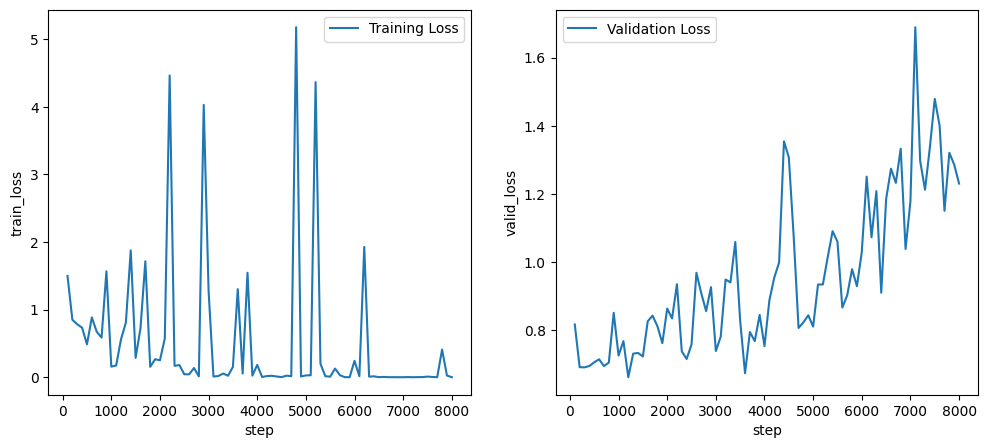

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x='step', y='train_loss', data=progress_df, label='Training Loss')
plt.subplot(1, 2, 2)
sns.lineplot(x='step', y='valid_loss', data=progress_df, label='Validation Loss')
plt.show()

### Testing model on test data

In [45]:
def test_model(net, test_loader, criterion):
  net.eval()
  test_losses = []
  num_correct = 0

  for inputs, labels in test_loader:

      test_output, test_h = net(inputs)
      loss = criterion(test_output, labels)
      test_losses.append(loss.item())

      preds = torch.round(test_output.squeeze())
      correct_tensor = preds.eq(labels.float().view_as(preds))
      correct = np.squeeze(correct_tensor.numpy())
      num_correct += np.sum(correct)
  net.train()
  print("Test Loss: {:.4f}".format(np.mean(test_losses)))
  print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

In [46]:
test_model(net, test_loader, criterion)

Test Loss: 1.5611
Test Accuracy: 0.72


# Exercise 2

In [80]:
sentence = """The larger Broncos will be available with 35-inch off-road tires and will be able to drive through water nearly 3 feet, 10 inches deep. It has independent front suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used on almost all modern passenger vehicles, generally provides a smoother ride and better on - road handling than a single solid axle. It still has a solid axle in the back though, like most pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available with a choice of either a 10-speed automatic or seven-speed manual transmission. (The manual transmission will have six gears for ordinary driving, plus a seventh for low speed off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4- cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its capabilities. It also has more convenience features than the more truck-like Bronco. While it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still intended for serious off-road use. Ford engineers boasted of the off-road testing the prototypes have been put through, including driving through deep sand, up steep inclines , and crawling across boulder-strewn trails."""

In [81]:
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english'))


def preprocess_sentence(sentence):

  # Removing special characters and replacing with spaces
  sentence = re.sub(r'[^\w\s]', ' ', sentence)

  # Removing multiple spaces and replacing with single space
  sentence = re.sub(r'\s+', ' ', sentence)

  # Removing single characters
  sentence = re.sub(r'\b\w\b', '', sentence)

  # Converting to lowercase
  sentence = sentence.lower()

  # splitting sentence to individual words
  sentence = sentence.split()

  # Removing stopwords
  sentence = [word for word in sentence if word not in stop_words]

  # Tokenizing words
  tokens = word_tokenize(' '.join(sentence))

  # lemmatizing words
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]

  # stemming words
  stemmer = PorterStemmer()
  stemmed_words = [stemmer.stem(word) for word in lemmatized_words]
  return lemmatized_words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [82]:
preprocessed_sentence = preprocess_sentence(sentence)

### Finding overall sentiment and subjectivity using TextBlob

In [83]:
from textblob import TextBlob

blob = TextBlob(' '.join(preprocessed_sentence))
sentiment = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(f"Overall sentiment: {sentiment:.2f}")
print(f"Subjectivity: {subjectivity:.2f}")

Overall sentiment: 0.07
Subjectivity: 0.39


The text registers a 0.07 positive score on sentiment while its subjectivity levels reach 0.39 on the scale. Hence the sentence demonstrates neutral tendencies with a mild positive orientation offering factual details and subjective viewpoints.